In [18]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install zemberek-python
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import emoji
from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from snowballstemmer import TurkishStemmer
ts = TurkishStemmer()
ps = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
dataset = pd.read_excel("drive/MyDrive/tubitakproje/tubitak/dataset.xlsx")
dataset.head()

,Haberler,Sonuc
0,Kanada-Fas maçında TRT spikerinin devre arasın...,True
1,Bir öğrencinin eksi netle Cumhuriyet Üniversit...,True
2,Taksim saldırısıyla ilgili önergenin AK Parti ...,True
3,Fotoğrafın 19 cm ile dünyanın en uzun burunlu ...,True
4,Ayın arkasında Satürn’ün belirdiği videonun ge...,True


In [22]:
dataset.shape

(1568, 2)

In [23]:
f = open("drive/MyDrive/tubitakproje/tubitak/turkce-stop-words.txt", "r")
turKStopWords=[i[:-1] for i in f]

In [24]:
# Döngüyle veri kümesindeki her bir satır için işlemler gerçekleştiriliyor
for i in range(0, dataset.shape[0]):
    tokenizer = TurkishTokenizer.DEFAULT
    
    # İlgili satırdaki metinden noktalama işaretleri kaldırılıyor ve küçük harfe dönüştürülüyor
    cumle = "".join(v for v in dataset.iloc[i, 0] if v not in string.punctuation).lower()
    
    # Metinden rakamlar çıkarılıyor
    cumle = re.sub(r'\d', '', cumle)
    
    # Metinden URL'ler çıkarılıyor
    cumle = re.sub('https\S+', '', cumle)
    
    # Metinden HTML etiketleri çıkarılıyor
    html_pattern = r'<.*?>'
    cumle = re.sub(pattern=html_pattern, repl=' ', string=cumle)
    
    # Metindeki emoji'lerin yerine boşluk karakteri ekleniyor
    deneme = emoji.emoji_list(cumle)
    for j in range(len(deneme) - 1, -1, -1):
        deger = deneme[j]['match_start']
        cumle = cumle.replace(cumle[deger], " ")
    
    # Metin parçacıklarına ayrılıyor (tokenization)
    tokens = tokenizer.tokenize(cumle)
    
    # Stop kelimeleri ve Türkçe stop kelimeleri listesinde yer almayan kelimeler filtreleniyor
    tokens = [w.content for w in tokens if not str(w.content).lower() in set(stopwords.words("turkish"))]
    tokens = [i for i in tokens if i not in turKStopWords and len(i) >= 2]
    
    # Düzenlenen kelimeler birleştirilerek yeni bir cümle oluşturuluyor
    duzenlenenCumle = " ".join(tokens)
    
    # Veri kümesindeki ilgili satır güncelleniyor
    dataset.iloc[i, 0] = duzenlenenCumle


In [25]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(dataset["Haberler"].values.astype('U'),
                                                dataset["Sonuc"].values.astype('U'),
                                                test_size=0.1,random_state=42) 

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x_train_counts=cv.fit_transform(x_train)
print(x_train_counts.shape)

(1411, 51806)


In [27]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer()
x_train_tfidf=tfidf_transformer.fit_transform(x_train_counts).toarray()
print(x_train_tfidf.shape)

(1411, 51806)


In [28]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7, metric="euclidean") 
knn.fit(x_train_tfidf,y_train)
x_test_counts=cv.transform(x_test)
x_test_tfidf=tfidf_transformer.transform(x_test_counts).toarray()
y_pred = knn.predict(x_test_tfidf) 
knncm = confusion_matrix(y_test, y_pred)  
knnskor=(accuracy_score(y_test, y_pred))
print("knn skoru skoru: ",knnskor )

knn skoru skoru:  0.8280254777070064


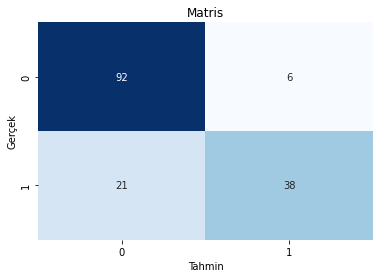

0.8280254777070064


In [30]:
sns.heatmap(knncm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") 
plt.ylabel("Gerçek")
plt.xlabel("Tahmin") 
plt.show()
print("knn skoru skoru : ",knnskor )

In [31]:
from sklearn.naive_bayes import GaussianNB
gnbmodel=GaussianNB()
gnbmodel.fit(x_train_tfidf,y_train)
x_test_counts=cv.transform(x_test)
x_test_tfidf=tfidf_transformer.transform(x_test_counts).toarray()
y_pred=gnbmodel.predict(x_test_tfidf)
gnbskor=accuracy_score(y_test,y_pred)
gnbcm=confusion_matrix(y_test,y_pred)
print("Gaussian naive bayes skoru : ",gnbskor )

Gaussian naive bayes skoru:  0.8535031847133758


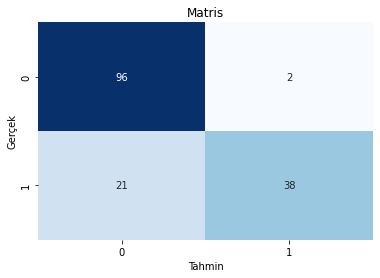

0.8535031847133758


In [32]:
sns.heatmap(gnbcm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") 
plt.ylabel("Gerçek")
plt.xlabel("Tahmin") 
plt.show()
print("Gaussian naive bayes skoru : ",gnbskor )

In [33]:
from sklearn.svm import SVC  
svc=SVC(kernel="rbf")        
svc=svc.fit(x_train_tfidf,y_train)
x_test_counts=cv.transform(x_test)
x_test_tfidf=tfidf_transformer.transform(x_test_counts).toarray()
y_pred=svc.predict(x_test_tfidf)   
svcskor=accuracy_score(y_test,y_pred)
svccm=confusion_matrix(y_test,y_pred)
print("Destek vektör makineleri skor : ",svcskor)

Destek vektör makineleri skor :  0.8789808917197452


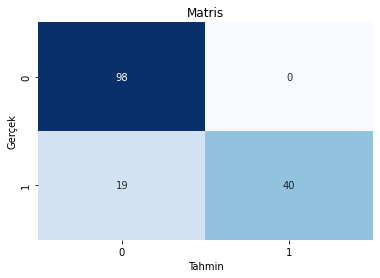

0.8789808917197452


In [34]:
sns.heatmap(svccm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") 
plt.ylabel("Gerçek")
plt.xlabel("Tahmin") 
plt.show()
print("Destek vektör makineleri skor : ",svcskor)

In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr=lr.fit(x_train_tfidf,y_train)
x_test_counts=cv.transform(x_test)
x_test_tfidf=tfidf_transformer.transform(x_test_counts).toarray()
y_pred = lr.predict(x_test_tfidf) 
lrskor=accuracy_score(y_test,y_pred)
lrcm=confusion_matrix(y_test,y_pred)
print("Logistic Resresyon skor : ",lrskor) 

Logistic Resresyon skor :  0.8407643312101911


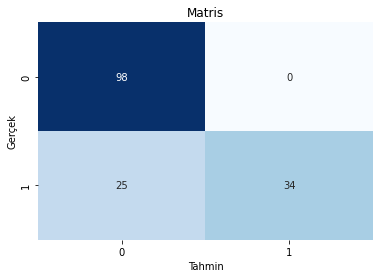

0.8407643312101911


In [36]:
sns.heatmap(lrcm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") 
plt.ylabel("Gerçek")
plt.xlabel("Tahmin") 
plt.show()
print("Logistic Resresyon skor : ",lrskor) 

In [37]:
from xgboost import XGBClassifier
xgb = XGBClassifier(eval_metric="rmse",max_depth=13)
xgb.fit(x_train_tfidf,y_train)
y_pred=xgb.predict(x_test_tfidf)
Xgbcm = confusion_matrix(y_test, y_pred) 
xgbskor=(accuracy_score(y_test, y_pred))
print("xgboost skor : ",xgbskor) 

xgboost skor :  0.910828025477707


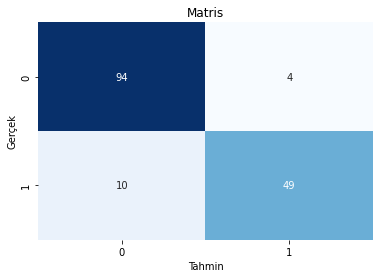

0.910828025477707


In [38]:
sns.heatmap(Xgbcm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") 
plt.ylabel("Gerçek")
plt.xlabel("Tahmin") 
plt.show()
print("xgboost skor : ",xgbskor) 

In [41]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
mnb.fit(x_train_tfidf,y_train)
x_test_counts=cv.transform(x_test)
x_test_tfidf=tfidf_transformer.transform(x_test_counts).toarray()
y_pred=mnb.predict(x_test_tfidf)
mnbskor=accuracy_score(y_test,y_pred)
mnbcm=confusion_matrix(y_test,y_pred)
print("MultinomialNB başarısı : ",mnbskor)

MultinomialNB başarısı: 0.8407643312101911


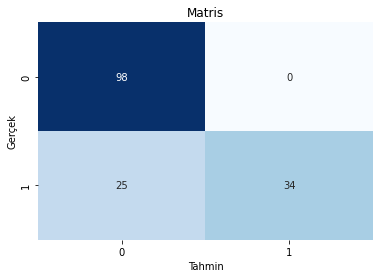

0.8407643312101911


In [42]:
sns.heatmap(mnbcm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") 
plt.ylabel("Gerçek")
plt.xlabel("Tahmin") 
plt.show()
print("MultinomialNB başarısı : ",mnbskor)

In [57]:
from sklearn.naive_bayes import BernoulliNB
bnb =BernoulliNB()
bnb.fit(x_train_tfidf,y_train)
x_test_counts=cv.transform(x_test)
x_test_tfidf=tfidf_transformer.transform(x_test_counts).toarray()
y_pred=bnb.predict(x_test_tfidf)
bnbskor=accuracy_score(y_test,y_pred)
bnbcm=confusion_matrix(y_test,y_pred)
print("BernoulliNB başarısı : ",bnbskor)

BernoulliNB başarısı :  0.8343949044585988


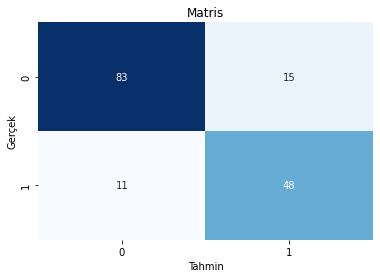

BernoulliNB başarısı :  0.8343949044585988


In [58]:
sns.heatmap(bnbcm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") 
plt.ylabel("Gerçek")
plt.xlabel("Tahmin")  
plt.show()
print("BernoulliNB başarısı : ",bnbskor)